# MCMC Introduction

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from py21cmmc.mcmc import analyse
from py21cmmc import mcmc

%load_ext autoreload
%autoreload 2

In this notebook we demonstrate how to do the simplest possible MCMC to fit just two astrophysical parameters to a series of coeval brightness temperature boxes without noise, and then visualise the results.

This tutorial will introduce the basic components of using ``py21cmmc`` for doing MCMC to fit parameters. For more advanced topics, see the relevant tutorials, guides or FAQs.

In [2]:
import py21cmmc
py21cmmc.__version__

'0.1.0'

## Running MCMC

First we create the two necessary components, a ``core`` and ``likelihood`` object. Multiple ``core`` and ``likelihood`` objects are allowed, and they will work together seamlessly. But we need *at least* one each.

The idea behind having ``core`` and ``likelihood`` modules is that the ``core`` is supposed to do the calculations to fill up what is called a ``context`` dictionary on every iteration of the MCMC. The ``likelihood`` then uses the contents of this ``context`` to evaluate a likelihood. 

In practice, there is no hard-and-fast limit to the scope of the ``core`` or ``likelihood``: the ``core`` could evaluate the likelihood itself, store it in the ``context``, and the ``likelihood`` could merely access and return it. Likewise, the ``core`` could do nothing, and let the ``likelihood`` perform the entire calculation. We chose to split their work based on two factors, one practical and the other philosophical:

1. All ``core`` modules are invoked (on any given iteration) before any of the ``likelihood`` modules. This means that whatever gets calculated in the ``core`` modules and added to the single ``context`` is available to all the ``likelihood`` modules. Often, several ``likelihood`` modules will need access to the same underlying simulation, and therefore it is most efficient to perform this simulation in the ``core`` and access it from each ``likelihood`` in turn. Each ``likelihood`` is combined assuming they contribute *independently*, so they can be amassed arbitrarily so long as this is a valid statistical statement.
2. We tend to implement ``core`` modules as "constructive" and ``likelihood`` modules as "reductive". That is, ``core`` modules forward model from bare statistical/physical parameters to something very close to what should be *measured* by a given instrument, while ``likelihood`` modules simulate the process of processing that observation/measurement into a likelihood. This will tend to give the least possible overlap of processing between modules.

Given these considerations, the ``core`` modules that are implemented within ``py21cmmc`` perform ``21cmFAST`` simulations and add these large datasets to the ``context``, while the various ``likelihoods`` will use this "raw" data and compress it down to a likelihood -- either by taking a power spectrum, global average or some other reduction. 

The neat thing about ``py21cmmc`` is that it is *extensible* -- new ``core`` and ``likelihood`` modules can be written to simply join the ones that are implemented within ``py21cmmc`` to offer a limitless breadth of fitting complexity. But we will show this in more detail in another tutorial.

In *this* tutorial we use a single ``core`` -- one which evaluates the coeval brightness temperature field at an arbitrary selection of redshifts, and a single ``likelihood`` -- one which reduces the 3D field(s) into a 1D power spectrum/spectra and evaluates the likelihood based on a $\chi$-square fit to data.

Of course, some ``likelihood`` modules will *require* specific ``core`` module(s) to be loaded in order to work; for those defined in ``py21cmmc``, this will be immediately picked up and a helpful error message raised if this is not the case.

Every ``likelihood`` within ``py21cmmc`` contains a ``simulate()`` method, which will *simulate* the kind of data that the ``likelihood`` is meant to model. Typically, if no data file is passed to the likelihood *and the allow_simulate keyword is set*, this method will be automatically called to *produce* the data for the ensuing fit, which is a neat way to test the likelihood, and do theoretical studies.

Enough discussion, let's create our ``core`` and ``likelihood``:

In [3]:
core = mcmc.CoreCoevalModule( # All core modules are prefixed by Core* and end with *Module
    redshift = [7,8,9],          # Redshifts of the coeval fields produced.
    user_params = dict(       # Here we pass some user parameters. Also cosmo_params, astro_params and flag_options
        HII_DIM = 50,         # are available. These specify only the *base* parameters of the data, *not* the
        BOX_LEN = 125.0       # parameters that are fit by MCMC.
    ),
    regenerate=False          # Don't regenerate init_boxes or perturb_fields if they are already in cache.
) # For other available options, see the docstring.

# Now the likelihood...
datafiles = ["data/simple_mcmc_data_%s.npz"%z for z in core.redshift]

likelihood = mcmc.Likelihood1DPowerCoeval(  # All likelihood modules are prefixed by Likelihood*
    datafile = datafiles,                   # All likelihoods have this, which specifies where to write/read data
    noisefile= None,                        # All likelihoods have this, specifying where to find noise profiles.
    logk=False,                             # Should the power spectrum bins be log-spaced?
    min_k=0.1,                              # Minimum k to use for likelihood
    max_k=1.0,                              # Maximum ""
    simulate = True,                        # Simulate the data, instead of reading it in.
                                            # will be performed.
) # For other available options, see the docstring

Now we have all we need to start running the MCMC. The most important part of the call to ``run_mcmc`` is the specification of ``params``, which specifies which are the parameters *to be fit*. This is passed as a dictionary, where the keys are the parameter names, and *must* come from either ``cosmo_params`` or ``astro_params``, and be of ``float`` type. The values of the dictionary are length-4 lists: ``(guess, min, max, width)``. The first specifies where the best guess of the true value lies, and the initial walkers will be chosen around here. The ``min/max`` arguments provide upper and lower limits on the parameter, outside of which the likelihood will be ``-infinity``. The ``width`` affects the initial distribution of walkers around the best-guess (it does *not* influence any kind of "prior"). 

Finally, the ``model_name`` merely affects the file name of the output chain data, along with the ``datadir`` argument.

In [4]:
model_name = "SimpleTest"

chain = mcmc.run_mcmc(
    core, likelihood,        # Use lists if multiple cores/likelihoods required. These will be eval'd in order.
    datadir='data',          # Directory for all outputs
    model_name=model_name,   # Filename of main chain output
    params=dict(             # Parameter dict as described above.
        HII_EFF_FACTOR = [30.0, 10.0, 50.0, 3.0],
        ION_Tvir_MIN = [4.7, 2, 8, 0.1],
    ), 
    walkersRatio=3,         # The number of walkers will be walkersRatio*nparams
    burninIterations=0,      # Number of iterations to save as burnin. Recommended to leave as zero.
    sampleIterations=150,    # Number of iterations to sample, per walker.
    threadCount=6,           # Number of processes to use in MCMC (best as a factor of walkersRatio)
    continue_sampling=True  # Whether to contine sampling from previous run *up to* sampleIterations.
)

INFO:cosmoHammer:Using CosmoHammer 0.6.1
INFO:cosmoHammer:Using emcee 2.2.1
INFO:cosmoHammer:all burnin iterations already completed
INFO:cosmoHammer:Sampler: <class 'py21cmmc.mcmc.cosmoHammer.CosmoHammerSampler.CosmoHammerSampler'>
configuration: 
  Params: [30.   4.7]
  Burnin iterations: 0
  Samples iterations: 150
  Walkers ratio: 3
  Reusing burn in: True
  init pos generator: SampleBallPositionGenerator
  stop criteria: IterationStopCriteriaStrategy
  storage util: <py21cmmc.mcmc.cosmoHammer.storage.HDFStorageUtil object at 0x7f5480186240>
likelihoodComputationChain: 
Core Modules: 
  CoreCoevalModule
Likelihood Modules: 
  Likelihood1DPowerCoeval

INFO:cosmoHammer:reusing previous samples: 100 iterations
INFO:cosmoHammer:start sampling after burn in
INFO:cosmoHammer:Iteration finished:110
INFO:cosmoHammer:Iteration finished:120
INFO:cosmoHammer:Iteration finished:130
INFO:cosmoHammer:Iteration finished:140
INFO:cosmoHammer:Iteration finished:150
INFO:cosmoHammer:sampling done! T

## Analysis

### Accessing chain data

The full chain data, as well as any stored data (as "blobs") is available within the chain as the ``samples`` attribute.
If access to this "chain" object is lost (eg. the MCMC was run via CLI and is finished), an exact replica of the store object can be read in from file. Unified access is provided through the ``get_samples`` function in the ``analyse`` module. Thus all these are equivalent:

In [5]:
samples1 = chain.samples

samples2 = analyse.get_samples(chain)

samples3 = analyse.get_samples("data/%s"%model_name)

# Equivalent:
# samples = analyse.get_samples("data/%s"%model_name)

In [6]:
print(np.all(samples1.accepted == samples2.accepted))
print(np.all(samples1.accepted == samples3.accepted))

True
True


Do note that while the first two methods return exactly the same object, occupying the same memory:

In [7]:
samples1 is samples2

True

this is not true when reading in the samples from file:

In [8]:
print(samples1 is samples3)
del samples3; samples=samples1 # Remove unnecessary memory, and rename to samples

False


Several methods are defined on the sample object (which has type ``HDFStore``), to ease interactions. For example, one can access the various dimensions of the chain:

In [9]:
niter = samples.size
nwalkers, nparams = samples.shape

We can also check what the parameter names of the run were, and their initial "guess" (this is the first value passed to the "parameters" dictionary in ``run_mcmc``:

In [10]:
print(samples.param_names)
print([samples.param_guess[k] for k in samples.param_names])

('HII_EFF_FACTOR', 'ION_Tvir_MIN')
[array([30.]), array([4.7])]


Or one can view how many iterations were accepted for each walker:

In [11]:
samples.accepted, np.mean(samples.accepted/niter)

(array([65, 68, 81, 66, 73, 66]), 0.6983333333333334)

We can also  see what extra data we saved along the way by getting the blob names (see below for more details on this):

In [12]:
samples.blob_names

('k_z7', 'delta_z7', 'k_z8', 'delta_z8', 'k_z9', 'delta_z9')

Finally, we can get the actual chain data, using ``get_chain`` and friends. However, this is best done dynamically, as the ``samples`` object itself does *not* hold the chain in memory, rather transparently read it from file when accessed. 

### Trace Plot

Often, for diagnostic purposes, the most useful plot to start with is the trace plot. This enables quick diagnosis of burnin time and walkers that haven't converged. The function in ``py21cmmc`` by default plots the log probability along with the various parameters that were fit. It also supports setting a starting iteration, and a thinning amount. 

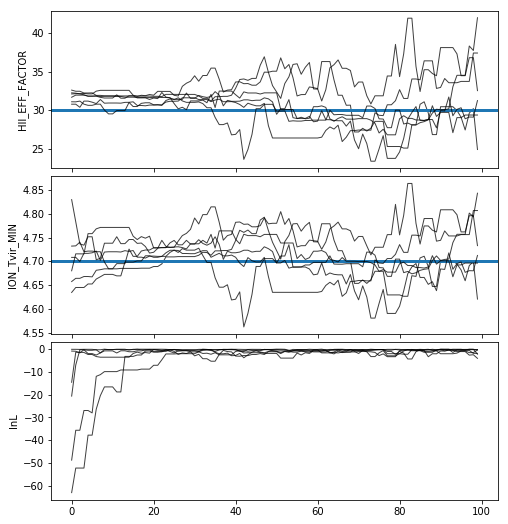

In [13]:
analyse.trace_plot(samples, include_lnl=True, start_iter=0, thin=1, colored=False, show_guess=True);

### Corner Plot

One of the most useful plots to come out of an MCMC analysis is the "corner" plot, which shows the correlation of each parameter with every other parameter. The function in ``py21cmmc`` will by default also show the original "guess" for each parameter as a blue line, and also show the log-likelihood as a psuedo-"parameter", though this can be turned off.

In [14]:
samples.param_guess

array([(30., 4.7)],
      dtype=[('HII_EFF_FACTOR', '<f8'), ('ION_Tvir_MIN', '<f8')])

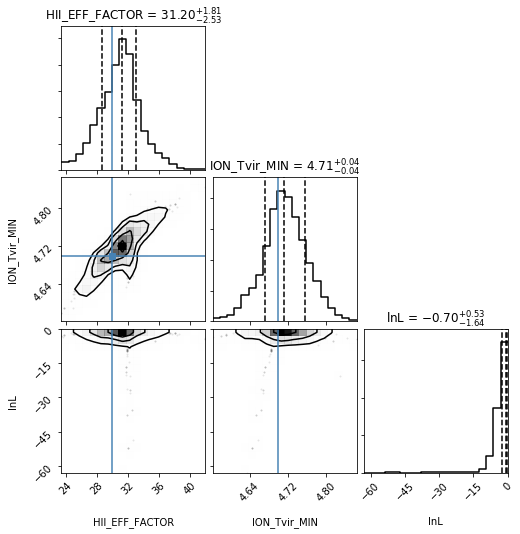

In [16]:
analyse.corner_plot(samples);

### Model Comparison Plot

Another plot of interest is a "model comparison" plot -- i.e. comparing the range of outputted models to the data itself. These will differ significantly depending on the kind of data produced by the likelihood function, and thus they depend also on the actual data used. We thus do not provide a general function for plotting this. We do however show how one might go about this task in the function below.

First, however, we show how one might interact with the data and saved models/blobs.

To extract all blob data from the samples:

In [17]:
blobs = samples.get_blobs()

For simplicity, let's extract each kind of blob from the blob structured array:

In [18]:
k = blobs['k_z7']
model_power = blobs['delta_z7'], blobs['delta_z8'], blobs['delta_z9']

print(k.shape, model_power[0].shape)
nk = k.shape[-1]

(100, 6, 22) (100, 6, 22)


Here we notice that ``k`` should be the same on each iteration, so we take just the first:

In [19]:
print(np.all(k[0] == k[1]))
k = k[0]

True


Finally, we also want to access the *data* to which the models have been compared. Since we have access to the original ``likelihood`` object, we can easily pull this from it. However, we equivalently could have read it in from file (this file is *not* always present, only if ``datafile`` is present in the likelihood constructor):

In [20]:
p_data = np.array([d['delta'] for d in likelihood.data])
k_data = np.array([d['k'] for d in likelihood.data])

# Equivalent
# data = np.genfromtxt("simple_mcmc_data.txt")
# k_data = data[:,0]
# p_data = data[:,1:]

Now, let's define a function which will plot our model comparison:

In [21]:
def model_compare_plot(samples, p_data, k_data, thin=1, start_iter=0):
    chain = samples.get_chain(thin=thin, discard=start_iter, flat=True)
    blobs = samples.get_blobs(thin=thin, discard=start_iter, flat=True)
    
    k = blobs['k_z7'][0]
    model_power = [blobs[name] for name in samples.blob_names if name.startswith("delta_")]
    
    print(k.shape)
    
    nz = len(model_power)
    nk = k.shape[-1]
    
    fig, ax = plt.subplots(1, nz, sharex=True, sharey=True, figsize=(6*nz, 4.5), 
                          subplot_kw={"xscale":'log', "yscale":'log'}, gridspec_kw={"hspace":0.05, 'wspace':0.05},
                          squeeze=False)

    for i in range(nz):
        this_power = model_power[i]
        this_data = p_data[i]

        label="models"

        for pp in this_power:
            ax[0,i].plot(k, pp, color='k', alpha=0.2, label=label, zorder=1)
            if label:
                label=None

        mean = np.mean(this_power, axis=0)
        std = np.std(this_power, axis=0)
        md = np.median(this_power, axis=0)

        ax[0,i].fill_between(k, mean - std, mean+std, color="C0", alpha=0.6)
        ax[0,i].plot(k, md, color="C0", label="median model")

        ax[0,i].errorbar(k_data, this_data, yerr = (0.15*this_data), color="C1", 
                     label="data", ls="None", markersize=5, marker='o')

        ax[0,i].set_xlabel("$k$ [Mpc$^{-3}$]", fontsize=15)
        ax[0,i].text(0.1, 0.86, "z=%s"%core.redshift[i], transform=ax[0,i].transAxes, fontsize=15, fontweight='bold')

    ax[0,0].legend(fontsize=12)
    #plt.ylim((3.1e2, 3.5e3))


    ax[0,0].set_ylabel("$\Delta^2_{21}$", fontsize=15)

#plt.savefig(join(direc, modelname+"_power_spectrum_plot.pdf"))

(22,)


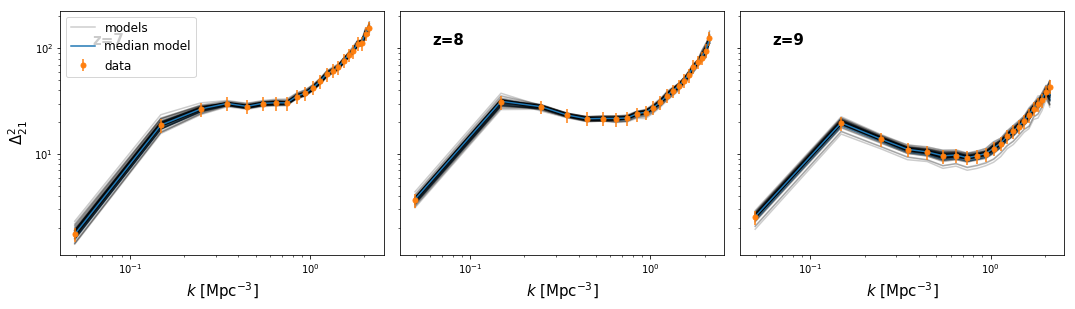

In [22]:
model_compare_plot(samples, p_data, k_data[0], thin=10)